## Data Ingestion

In [2]:
import os
import sys
import copy
import time
import random
import pyspark

from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc, size, max, abs, split, col
from pyspark.sql.functions import datediff,unix_timestamp, round
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType
import pyspark.sql.functions as F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mizani.formatters import date_format
from plotnine import *

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

import warnings
warnings.filterwarnings('ignore')

In [3]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Predictive Maintenance") \
        .config("spark.some.config.option", "some-value") \
        .config("spark.executor.memory", "70g")\
        .config("spark.driver.memory", "50g")\
        .config("spark.memory.offHeap.enabled", "true")\
        .config("spark.memory.offHeap.size","30g")\
        .getOrCreate()
    return spark

spark = init_spark()
spark.conf.set("spark.sql.session.timeZone", "UTC")

In [4]:
filename = "..\data\machines.csv"
machines = spark.read.csv(filename, sep=',', header=True)

print(machines.count())
machines.show()

100
+---------+------+---+
|machineID| model|age|
+---------+------+---+
|        1|model3| 18|
|        2|model4|  7|
|        3|model3|  8|
|        4|model3|  7|
|        5|model3|  2|
|        6|model3|  7|
|        7|model3| 20|
|        8|model3| 16|
|        9|model4|  7|
|       10|model3| 10|
|       11|model2|  6|
|       12|model3|  9|
|       13|model1| 15|
|       14|model3|  1|
|       15|model3| 14|
|       16|model1|  3|
|       17|model1| 14|
|       18|model3| 15|
|       19|model3| 17|
|       20|model2| 16|
+---------+------+---+
only showing top 20 rows



In [5]:
filename = "..\data\errors.csv"
errors = spark.read.csv(filename, sep=',', header=True)

print(errors.count())
errors.show()

3919
+-------------------+---------+-------+
|           datetime|machineID|errorID|
+-------------------+---------+-------+
|2015-01-03 07:00:00|        1| error1|
|2015-01-03 20:00:00|        1| error3|
|2015-01-04 06:00:00|        1| error5|
|2015-01-10 15:00:00|        1| error4|
|2015-01-22 10:00:00|        1| error4|
|2015-01-25 15:00:00|        1| error4|
|2015-01-27 04:00:00|        1| error1|
|2015-03-03 22:00:00|        1| error2|
|2015-03-05 06:00:00|        1| error1|
|2015-03-20 18:00:00|        1| error1|
|2015-03-26 01:00:00|        1| error2|
|2015-03-31 23:00:00|        1| error1|
|2015-04-19 06:00:00|        1| error2|
|2015-04-19 06:00:00|        1| error3|
|2015-04-29 19:00:00|        1| error4|
|2015-05-04 23:00:00|        1| error2|
|2015-05-12 09:00:00|        1| error1|
|2015-05-21 07:00:00|        1| error4|
|2015-05-24 02:00:00|        1| error3|
|2015-05-25 05:00:00|        1| error1|
+-------------------+---------+-------+
only showing top 20 rows



In [6]:
filename = "..\data\\failures.csv"
failures  = spark.read.csv(filename, sep=',', header=True)

print(failures.count())
failures.show()

761
+-------------------+---------+-------+
|           datetime|machineID|failure|
+-------------------+---------+-------+
|2015-01-05 06:00:00|        1|  comp4|
|2015-03-06 06:00:00|        1|  comp1|
|2015-04-20 06:00:00|        1|  comp2|
|2015-06-19 06:00:00|        1|  comp4|
|2015-09-02 06:00:00|        1|  comp4|
|2015-10-17 06:00:00|        1|  comp2|
|2015-12-16 06:00:00|        1|  comp4|
|2015-03-19 06:00:00|        2|  comp1|
|2015-03-19 06:00:00|        2|  comp2|
|2015-04-18 06:00:00|        2|  comp2|
|2015-12-29 06:00:00|        2|  comp2|
|2015-01-07 06:00:00|        3|  comp2|
|2015-02-06 06:00:00|        3|  comp1|
|2015-07-21 06:00:00|        3|  comp2|
|2015-10-04 06:00:00|        3|  comp2|
|2015-12-03 06:00:00|        3|  comp2|
|2015-01-17 06:00:00|        4|  comp2|
|2015-02-16 06:00:00|        4|  comp1|
|2015-04-02 06:00:00|        4|  comp2|
|2015-07-16 06:00:00|        4|  comp2|
+-------------------+---------+-------+
only showing top 20 rows



In [7]:
filename = "..\data\\maint.csv"
maintenance  = spark.read.csv(filename, sep=',', header=True)

print(maintenance.count())
maintenance.show()

3286
+-------------------+---------+-----+
|           datetime|machineID| comp|
+-------------------+---------+-----+
|2014-06-01 06:00:00|        1|comp2|
|2014-07-16 06:00:00|        1|comp4|
|2014-07-31 06:00:00|        1|comp3|
|2014-12-13 06:00:00|        1|comp1|
|2015-01-05 06:00:00|        1|comp4|
|2015-01-05 06:00:00|        1|comp1|
|2015-01-20 06:00:00|        1|comp3|
|2015-01-20 06:00:00|        1|comp1|
|2015-02-04 06:00:00|        1|comp4|
|2015-02-04 06:00:00|        1|comp3|
|2015-02-19 06:00:00|        1|comp3|
|2015-03-06 06:00:00|        1|comp1|
|2015-03-21 06:00:00|        1|comp1|
|2015-04-05 06:00:00|        1|comp3|
|2015-04-20 06:00:00|        1|comp2|
|2015-05-05 06:00:00|        1|comp3|
|2015-05-05 06:00:00|        1|comp2|
|2015-05-20 06:00:00|        1|comp2|
|2015-06-04 06:00:00|        1|comp3|
|2015-06-19 06:00:00|        1|comp1|
+-------------------+---------+-----+
only showing top 20 rows



In [8]:
filename = "..\data\\telemetry.csv"
telemetry = spark.read.csv(filename, sep=',', header=True)
telemetry_pd = pd.read_csv("..\data\\telemetry.csv")

print(telemetry.count())
telemetry.limit(10).toPandas().head(10)

876100


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853015625,418.504078221616,113.077935462083,45.0876857639276
1,2015-01-01 07:00:00,1,162.87922289706,402.747489565395,95.4605253823187,43.4139726834815
2,2015-01-01 08:00:00,1,170.989902405567,527.349825452291,75.2379048586662,34.1788471214451
3,2015-01-01 09:00:00,1,162.462833264092,346.149335043074,109.248561276504,41.1221440884256
4,2015-01-01 10:00:00,1,157.61002119306,435.376873016938,111.886648210168,25.9905109982024
5,2015-01-01 11:00:00,1,172.504839196295,430.323362106675,95.9270416939636,35.6550173268837
6,2015-01-01 12:00:00,1,156.556030606329,499.071623068962,111.755684290096,42.7539196974773
7,2015-01-01 13:00:00,1,172.522780814836,409.624717000438,101.00108276407,35.4820086610704
8,2015-01-01 14:00:00,1,175.324523915223,398.648780707752,110.624360548654,45.4822868466294
9,2015-01-01 15:00:00,1,169.218423246933,460.850669930244,104.848229967003,39.9017354356787


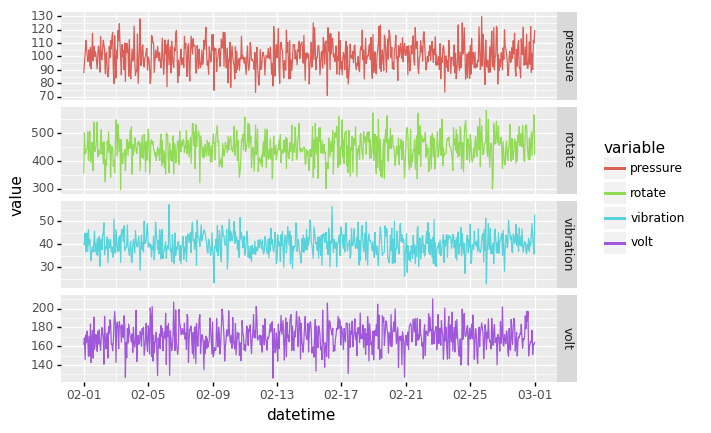

<ggplot: (-9223371906675654396)>

In [9]:
plt_data = telemetry_pd.loc[telemetry_pd['machineID'] == 1]

# format datetime field which comes in as string
plt_data['datetime'] = pd.to_datetime(plt_data['datetime'], format="%Y-%m-%d %H:%M:%S")


# Quick plot to show structure
plot_df = plt_data.loc[(plt_data['datetime'] >= pd.to_datetime('2015-02-01')) &
                       (plt_data['datetime'] <= pd.to_datetime('2015-03-01'))]

plt_data = pd.melt(plot_df, id_vars=['datetime', 'machineID'])

ggplot(aes(x="datetime", y="value", color = "variable", group="variable"), plt_data) +\
    geom_line() +\
    scale_x_date(labels=date_format('%m-%d')) +\
    facet_grid('variable ~ .', scales='free_y')

In [10]:
def plot_ts(series, figsize=(40, 20), title=None, xlabel="", ylabel=""):
    """
    Plot Time Series data. The series object should have date or time as index.
    
    series: Series object to be plotted.
    """
    series.plot(figsize=figsize, title=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def plot_ts2(ax, values, times, label=None, color='blue', xmin=None, xmax=None, ymin=None, ymax=None, anomalies=None):
    step = 700
    if xmin is not None:
        assert(xmax is not None)
        ax.set(xlim=(xmin, xmax))
    if ymin is not None:
        assert(ymax is not None)
        ax.set(ylim=(ymin, ymax))
    if xmin is None:
        ax.set_xticks([i for i in range(len(values)) if i % step == 0])
        ax.set_xticklabels([times[i] for i in range(len(values)) if i % step == 0])
    ax.plot(values, label=label, color=color)
    if anomalies is not None:
        x, y = anomalies
        ax.scatter(x, y, label='Anomalies', color='red')
    if label is not None:
        ax.legend()

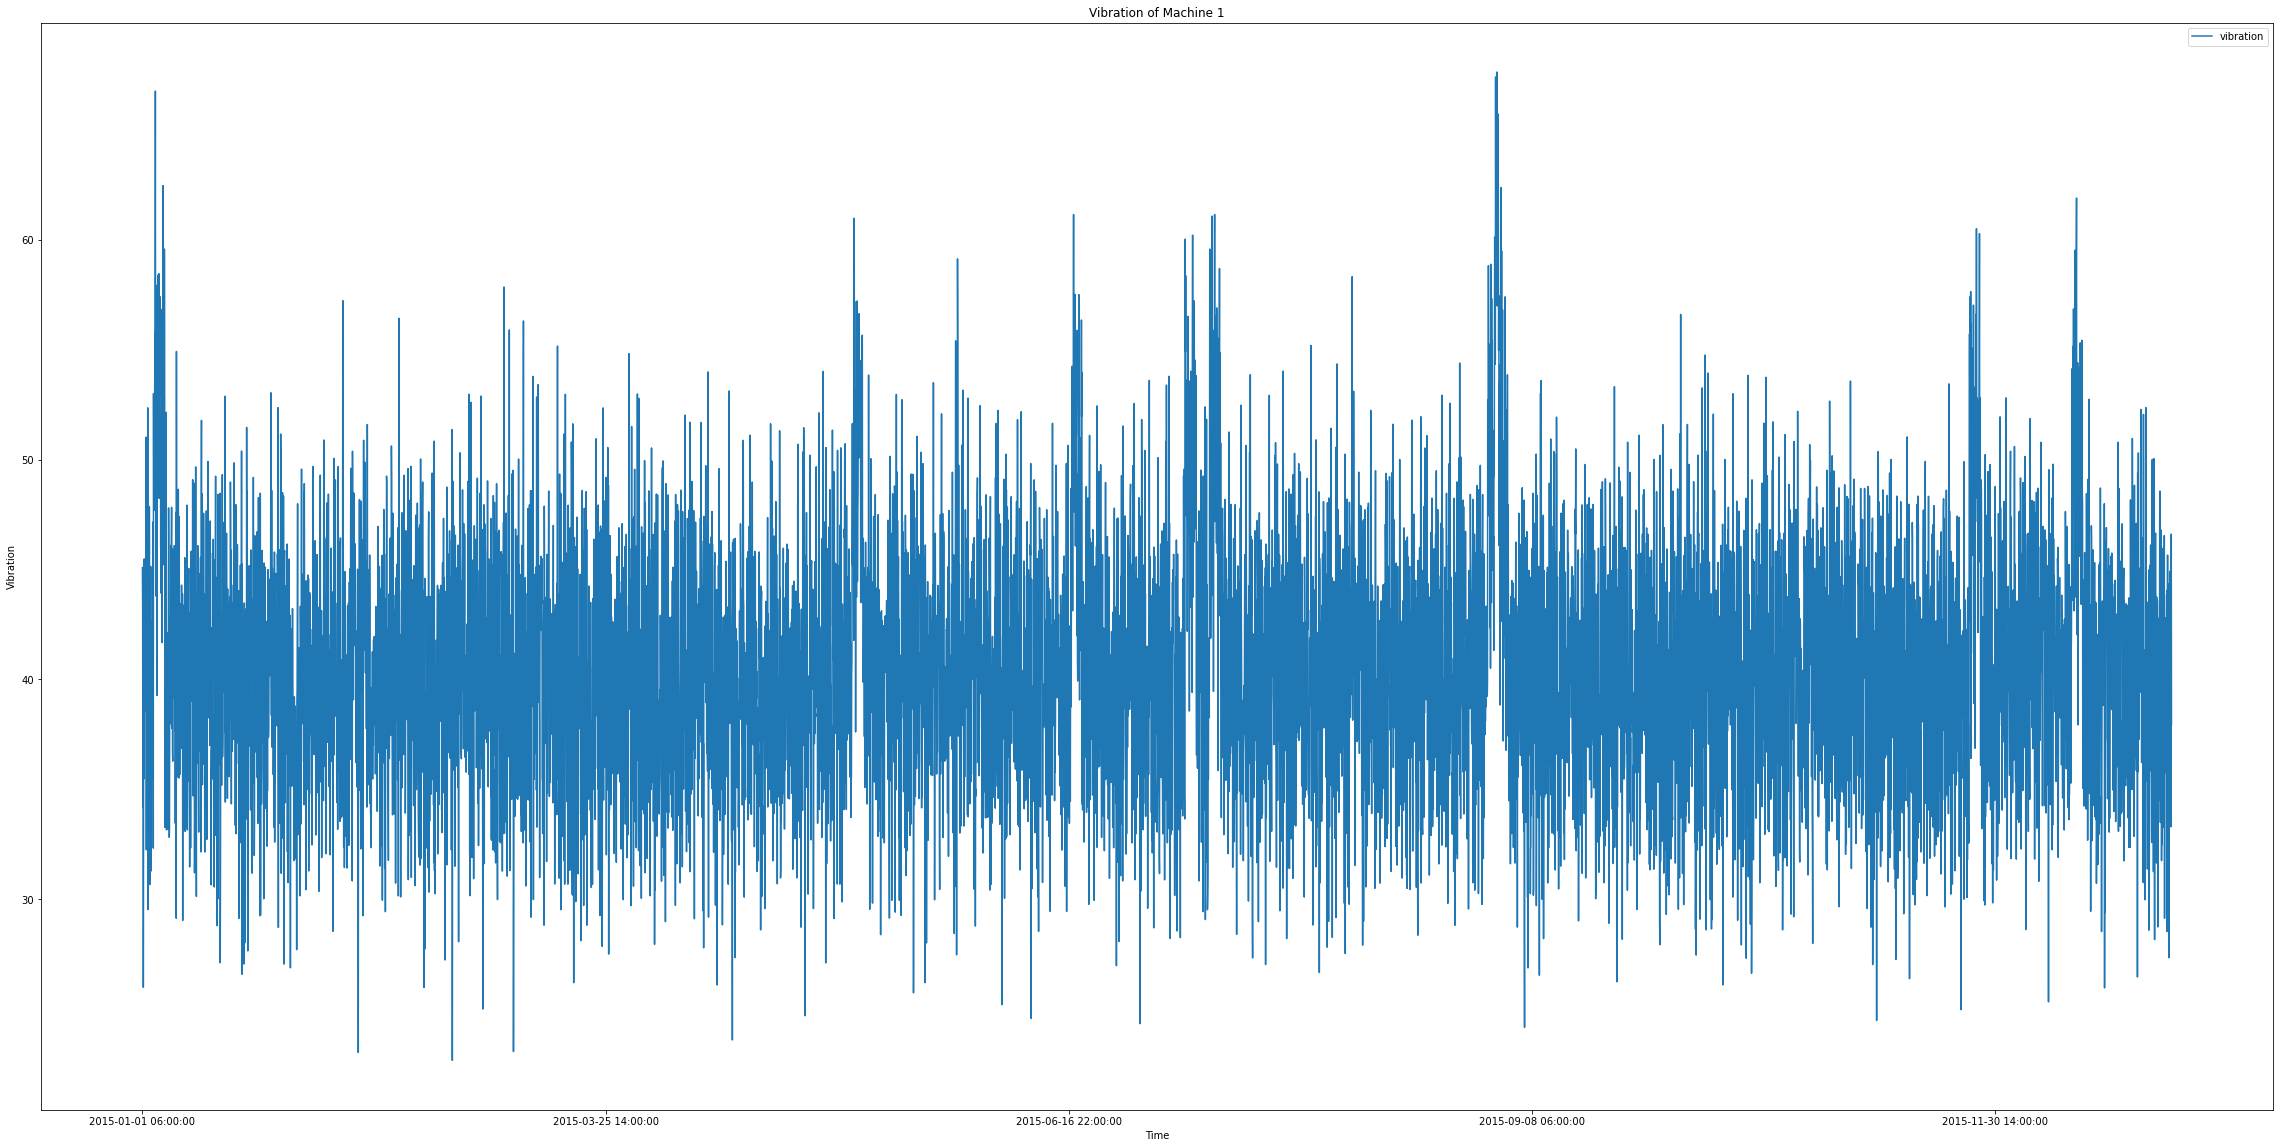

In [11]:
#telemetry_values = telemetry['volt']
#telemetry_dates = telemetry['datetime']
#plot_ts(ax, telemetry_values, telemetry_dates, label="volt", color='green')

df_vib_machine_1 = telemetry_pd[
    telemetry_pd.machineID == 1][["datetime", "vibration"]].set_index("datetime")

plot_ts(df_vib_machine_1, title="Vibration of Machine 1", xlabel="Time", ylabel="Vibration")

# Time Window

In [12]:
# rolling mean and standard deviation
# Temporary storage for rolling means
tel_mean = telemetry

# Engineer features
rolling_features = ['volt','rotate', 'pressure', 'vibration']
      
# n hours = n * 3600 seconds  
time_val = 3 * 3600 #12 * 3600

# Choose the time_val hour timestamps to align the data
# dt_truncated looks at the column named "datetime" in the current data set.
# remember that Spark is lazy... this doesn't execute until it is in a withColumn statement.
# test = tel_mean.withColumn("dt_truncated", dt_truncated).drop('volt', 'rotate', 'pressure', 'vibration').show()
dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))

In [14]:
lags = [3, 12, 24] #[12, 24, 36] #in hours

# align the data
for lag_n in lags:
    wSpec = Window.partitionBy('machineID').orderBy('datetime').rowsBetween(1-lag_n, 0)
    for col_name in rolling_features:
        tel_mean = tel_mean.withColumn(col_name+'_rollingmean_'+str(lag_n), 
                                       F.avg(col(col_name)).over(wSpec))
        tel_mean = tel_mean.withColumn(col_name+'_rollingstd_'+str(lag_n), 
                                       F.stddev(col(col_name)).over(wSpec))

# Calculate lag values...
telemetry_feat = (tel_mean.withColumn("dt_truncated", dt_truncated)
                  .drop('volt', 'rotate', 'pressure', 'vibration')
                  .fillna(0)
                  .groupBy("machineID","dt_truncated")
                  .agg(F.mean(f'volt_rollingmean_{lags[0]}').alias(f'volt_rollingmean_{lags[0]}'),
                       F.mean(f'rotate_rollingmean_{lags[0]}').alias(f'rotate_rollingmean_{lags[0]}'), 
                       F.mean(f'pressure_rollingmean_{lags[0]}').alias(f'pressure_rollingmean_{lags[0]}'), 
                       F.mean(f'vibration_rollingmean_{lags[0]}').alias(f'vibration_rollingmean_{lags[0]}'), 
                       F.mean(f'volt_rollingmean_{lags[1]}').alias(f'volt_rollingmean_{lags[1]}'),
                       F.mean(f'rotate_rollingmean_{lags[1]}').alias(f'rotate_rollingmean_{lags[1]}'), 
                       F.mean(f'pressure_rollingmean_{lags[1]}').alias(f'pressure_rollingmean_{lags[1]}'), 
                       F.mean(f'vibration_rollingmean_{lags[1]}').alias(f'vibration_rollingmean_{lags[1]}'),
                       F.mean(f'volt_rollingmean_{lags[2]}').alias(f'volt_rollingmean_{lags[2]}'),
                       F.mean(f'vibration_rollingmean_{lags[2]}').alias(f'vibration_rollingmean_{lags[2]}'),
                       F.mean(f'rotate_rollingmean_{lags[2]}').alias(f'rotate_rollingmean_{lags[2]}'), 
                       F.mean(f'pressure_rollingmean_{lags[2]}').alias(f'pressure_rollingmean_{lags[2]}'), 
                       F.stddev(f'volt_rollingstd_{lags[0]}').alias(f'volt_rollingstd_{lags[0]}'),
                       F.stddev(f'rotate_rollingstd_{lags[0]}').alias(f'rotate_rollingstd_{lags[0]}'), 
                       F.stddev(f'pressure_rollingstd_{lags[0]}').alias(f'pressure_rollingstd_{lags[0]}'), 
                       F.stddev(f'vibration_rollingstd_{lags[0]}').alias(f'vibration_rollingstd_{lags[0]}'), 
                       F.stddev(f'volt_rollingstd_{lags[1]}').alias(f'volt_rollingstd_{lags[1]}'),
                       F.stddev(f'rotate_rollingstd_{lags[1]}').alias(f'rotate_rollingstd_{lags[1]}'), 
                       F.stddev(f'pressure_rollingstd_{lags[1]}').alias(f'pressure_rollingstd_{lags[1]}'), 
                       F.stddev(f'vibration_rollingstd_{lags[1]}').alias(f'vibration_rollingstd_{lags[1]}'),
                       F.stddev(f'volt_rollingstd_{lags[2]}').alias(f'volt_rollingstd_{lags[2]}'),
                       F.stddev(f'rotate_rollingstd_{lags[2]}').alias(f'rotate_rollingstd_{lags[2]}'), 
                       F.stddev(f'pressure_rollingstd_{lags[2]}').alias(f'pressure_rollingstd_{lags[2]}'), 
                       F.stddev(f'vibration_rollingstd_{lags[2]}').alias(f'vibration_rollingstd_{lags[2]}'), ))

print(tel_mean.count())
print(telemetry_feat.count())
telemetry_feat.where((col("machineID") == 2)).limit(20).toPandas().head(20)

876100
292100


,machineID,dt_truncated,volt_rollingmean_3,rotate_rollingmean_3,pressure_rollingmean_3,vibration_rollingmean_3,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,...,pressure_rollingstd_3,vibration_rollingstd_3,volt_rollingstd_12,rotate_rollingstd_12,pressure_rollingstd_12,vibration_rollingstd_12,volt_rollingstd_24,rotate_rollingstd_24,pressure_rollingstd_24,vibration_rollingstd_24
0,2,2015-01-01 06:00:00,171.989696,426.561362,84.730951,42.142065,171.989696,426.561362,84.730951,42.142065,...,17.451237,3.249967,9.138435,3.874399,17.451237,3.249967,9.138435,3.874399,17.451237,3.249967
1,2,2015-01-01 09:00:00,169.792139,444.788523,96.747612,39.960014,169.717240,439.776019,94.387648,40.349707,...,2.618244,1.276744,0.647166,3.319012,1.276130,0.468370,0.647166,3.319012,1.276130,0.468370
2,2,2015-01-01 12:00:00,182.824918,434.673280,103.711544,44.429463,175.369585,437.522907,98.336808,42.070060,...,3.071257,1.639422,0.442494,1.429848,0.482509,0.829303,0.442494,1.429848,0.482509,0.829303
3,2,2015-01-01 15:00:00,170.516077,464.673688,100.277296,38.117914,174.066945,445.989496,98.978185,40.922957,...,2.739107,2.817279,0.402423,1.611216,0.419529,0.362409,0.402423,1.611216,0.419529,0.362409
4,2,2015-01-01 18:00:00,174.738896,421.407477,104.733537,41.450567,174.468007,441.385742,101.367497,40.989489,...,2.464793,2.532533,0.949902,0.935448,1.666974,0.060360,0.774834,0.601774,0.377414,0.172641
5,2,2015-01-01 21:00:00,173.541011,457.118541,100.564378,41.731281,175.405225,444.468246,102.321689,41.432306,...,1.605291,1.774005,0.026667,1.381326,0.888577,0.195698,0.361306,0.497742,0.183342,0.047131
6,2,2015-01-02 00:00:00,172.251803,460.268297,99.596045,44.616571,172.761946,450.867001,101.292814,41.479083,...,2.285440,0.381270,0.407527,0.420354,0.463667,0.208437,0.319093,0.946766,0.100209,0.072440
7,2,2015-01-02 03:00:00,167.986973,440.735979,86.753970,44.949244,172.129670,444.882574,97.911982,43.186916,...,2.228210,0.153024,0.507399,3.239491,0.450765,0.805138,0.228856,1.152375,0.143042,0.095903
8,2,2015-01-02 06:00:00,164.895176,437.702179,89.791238,38.112625,169.668741,448.956249,94.176408,42.352430,...,2.842215,1.354349,2.265543,1.032683,0.218930,0.594534,0.205590,0.644167,0.620550,0.239272
9,2,2015-01-02 09:00:00,164.018297,447.341538,101.057801,36.945995,167.288062,446.511998,94.299763,41.156109,...,4.930282,0.108653,0.210096,6.775421,0.715524,0.344508,0.099948,3.956291,0.167815,0.249741


In [15]:
# create a column for each errorID 
error_ind = (errors.groupBy("machineID","datetime","errorID").pivot('errorID')
             .agg(F.count('machineID').alias('dummy')).drop('errorID').fillna(0)
             .groupBy("machineID","datetime")
             .agg(F.sum('error1').alias('error1sum'), 
                  F.sum('error2').alias('error2sum'), 
                  F.sum('error3').alias('error3sum'), 
                  F.sum('error4').alias('error4sum'), 
                  F.sum('error5').alias('error5sum')))

# join the telemetry data with errors
error_count = (telemetry.join(error_ind, 
                              ((telemetry['machineID'] == error_ind['machineID']) 
                               & (telemetry['datetime'] == error_ind['datetime'])), "left")
               .drop('volt', 'rotate', 'pressure', 'vibration')
               .drop(error_ind.machineID).drop(error_ind.datetime)
               .fillna(0))

error_features = ['error1sum','error2sum', 'error3sum', 'error4sum', 'error5sum']

wSpec = Window.partitionBy('machineID').orderBy('datetime').rowsBetween(1-24, 0)
for col_name in error_features:
    # We're only interested in the erros in the previous 24 hours.
    error_count = error_count.withColumn(col_name+ f'_rollingmean_{lags[1]}', 
                                         F.avg(col(col_name)).over(wSpec))

error_feat = (error_count.withColumn("dt_truncated", dt_truncated)
              .drop('error1sum', 'error2sum', 'error3sum', 'error4sum', 'error5sum').fillna(0)
              .groupBy("machineID","dt_truncated")
              .agg(F.mean(f'error1sum_rollingmean_{lags[1]}').alias(f'error1sum_rollingmean_{lags[1]}'), 
                   F.mean(f'error2sum_rollingmean_{lags[1]}').alias(f'error2sum_rollingmean_{lags[1]}'), 
                   F.mean(f'error3sum_rollingmean_{lags[1]}').alias(f'error3sum_rollingmean_{lags[1]}'), 
                   F.mean(f'error4sum_rollingmean_{lags[1]}').alias(f'error4sum_rollingmean_{lags[1]}'), 
                   F.mean(f'error5sum_rollingmean_{lags[1]}').alias(f'error5sum_rollingmean_{lags[1]}')))

print(error_feat.count())
error_feat.limit(10).toPandas().head(10)

292100


,machineID,dt_truncated,error1sum_rollingmean_12,error2sum_rollingmean_12,error3sum_rollingmean_12,error4sum_rollingmean_12,error5sum_rollingmean_12
0,51,2015-01-01 06:00:00,0.0,0.0,0.0,0.0,0.0
1,51,2015-01-01 09:00:00,0.0,0.0,0.0,0.0,0.0
2,51,2015-01-01 12:00:00,0.0,0.0,0.0,0.0,0.0
3,51,2015-01-01 15:00:00,0.0,0.0,0.0,0.0,0.0
4,51,2015-01-01 18:00:00,0.0,0.0,0.0,0.0,0.0
5,51,2015-01-01 21:00:00,0.0,0.0,0.0,0.0,0.0
6,51,2015-01-02 00:00:00,0.0,0.0,0.0,0.0,0.0
7,51,2015-01-02 03:00:00,0.0,0.0,0.0,0.0,0.0
8,51,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
9,51,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0


In [16]:
# create a column for each component replacement
maint_replace = (maintenance.groupBy("machineID","datetime","comp").pivot('comp')
                 .agg(F.count('machineID').alias('dummy')).fillna(0)
                 .groupBy("machineID","datetime")
                 .agg(F.sum('comp1').alias('comp1sum'), 
                      F.sum('comp2').alias('comp2sum'), 
                      F.sum('comp3').alias('comp3sum'),
                      F.sum('comp4').alias('comp4sum')))

maint_replace = maint_replace.withColumnRenamed('datetime','datetime_maint')

print(maint_replace.count())
maint_replace.limit(10).toPandas().head(10)

2528


,machineID,datetime_maint,comp1sum,comp2sum,comp3sum,comp4sum
0,41,2015-08-30 06:00:00,0,0,1,0
1,99,2015-04-03 06:00:00,0,1,0,0
2,7,2015-02-08 06:00:00,1,1,0,0
3,39,2015-05-16 06:00:00,1,0,0,0
4,53,2015-02-12 06:00:00,0,0,0,1
5,26,2015-03-07 06:00:00,0,1,0,0
6,98,2015-05-15 06:00:00,1,0,0,0
7,1,2015-02-04 06:00:00,0,0,1,1
8,77,2015-04-26 06:00:00,1,0,1,0
9,23,2015-02-04 06:00:00,1,0,0,0


In [17]:
# We want to align the component information on telemetry features timestamps.
telemetry_times = telemetry_feat.select(telemetry_feat.machineID, telemetry_feat.dt_truncated)\
                    .withColumnRenamed('dt_truncated','datetime_tel')

# Grab 4 component
for i in range(4):
    maint_comp = maint_replace.where(col(f'comp{i+1}sum') == '1')\
                    .withColumnRenamed('datetime','datetime_maint')\
                    .drop(f'comp{(i+1)%4+1}sum', f'comp{(i+2)%4+1}sum', f'comp{(i+3)%4+1}sum')

    # Within each machine, get the last replacement date for each timepoint
    maint_tel_comp = telemetry_times.join(maint_comp, 
                    ((telemetry_times['machineID']== maint_comp['machineID']) 
                    & (telemetry_times['datetime_tel'] > maint_comp['datetime_maint'])
                    & ( maint_comp[f'comp{i+1}sum'] == '1')))\
                       .drop(maint_comp.machineID)

    # Calculate the number of days between replacements
    comp = maint_tel_comp.withColumn(f'sincelastcomp{i+1}', 
            datediff(maint_tel_comp.datetime_tel, maint_tel_comp.datetime_maint))\
            .drop(maint_tel_comp.datetime_maint).drop(maint_tel_comp[f'comp{i+1}sum'])
    #print(comp.count())
    #comp.filter(comp.machineID == '1').orderBy(comp.datetime_tel).limit(20).toPandas().head(20)
    
    # Join component
    if i+1 == 1:
        comps_feat = comp
    else:
        comps_feat = (comps_feat.join(comp, 
            ((comps_feat['machineID'] == comp['machineID']) & 
             (comps_feat['datetime_tel'] == comp['datetime_tel'])), "left")\
           .drop(comp.machineID).drop(comp.datetime_tel))
    
comps_feat = comps_feat.groupBy("machineID", "datetime_tel")\
                   .agg(F.max('sincelastcomp1').alias('sincelastcomp1'), 
                        F.max('sincelastcomp2').alias('sincelastcomp2'), 
                        F.max('sincelastcomp3').alias('sincelastcomp3'), 
                        F.max('sincelastcomp4').alias('sincelastcomp4'))\
                   .fillna(0)
comps_feat.filter(comps_feat.machineID == '1').orderBy(comps_feat.datetime_tel).limit(20).toPandas().head(20)

,machineID,datetime_tel,sincelastcomp1,sincelastcomp2,sincelastcomp3,sincelastcomp4
0,1,2015-01-01 06:00:00,19,214,154,169
1,1,2015-01-01 09:00:00,19,214,154,169
2,1,2015-01-01 12:00:00,19,214,154,169
3,1,2015-01-01 15:00:00,19,214,154,169
4,1,2015-01-01 18:00:00,19,214,154,169
5,1,2015-01-01 21:00:00,19,214,154,169
6,1,2015-01-02 00:00:00,20,215,155,170
7,1,2015-01-02 03:00:00,20,215,155,170
8,1,2015-01-02 06:00:00,20,215,155,170
9,1,2015-01-02 09:00:00,20,215,155,170


In [18]:
# Choose the time_val hour timestamps to align the data
dt_truncated = ((round(unix_timestamp(col("datetime_tel")) / time_val) * time_val).cast("timestamp"))

# Collect data
maint_feat = (comps_feat.withColumn("dt_truncated", dt_truncated)
              .groupBy("machineID","dt_truncated")
              .agg(F.mean('sincelastcomp1').alias('comp1sum'), 
                   F.mean('sincelastcomp2').alias('comp2sum'), 
                   F.mean('sincelastcomp3').alias('comp3sum'), 
                   F.mean('sincelastcomp4').alias('comp4sum')))

print(maint_feat.count())
maint_feat.limit(10).toPandas().head(10)

292100


,machineID,dt_truncated,comp1sum,comp2sum,comp3sum,comp4sum
0,1,2015-01-12 12:00:00,30.0,225.0,165.0,180.0
1,1,2015-02-08 18:00:00,57.0,252.0,192.0,207.0
2,1,2015-04-15 06:00:00,123.0,318.0,258.0,273.0
3,1,2015-05-28 06:00:00,166.0,361.0,301.0,316.0
4,1,2015-06-03 12:00:00,172.0,367.0,307.0,322.0
5,1,2015-06-06 21:00:00,175.0,370.0,310.0,325.0
6,1,2015-06-09 09:00:00,178.0,373.0,313.0,328.0
7,1,2015-06-14 09:00:00,183.0,378.0,318.0,333.0
8,1,2015-07-09 06:00:00,208.0,403.0,343.0,358.0
9,1,2015-07-25 18:00:00,224.0,419.0,359.0,374.0


In [19]:
# one hot encoding of the machine's model
catVarNames = ['model']  
sIndexers = [StringIndexer(inputCol=x, outputCol=x + '_indexed') for x in catVarNames]
machines_cat = Pipeline(stages=sIndexers).fit(machines).transform(machines)

# one-hot encode
ohEncoders = [OneHotEncoder(inputCol=x + '_indexed', outputCol=x + '_encoded')
              for x in catVarNames]

ohPipelineModel = Pipeline(stages=ohEncoders).fit(machines_cat)
machines_cat = ohPipelineModel.transform(machines_cat)

drop_list = [col_n for col_n in machines_cat.columns if 'indexed' in col_n]

machines_feat = machines_cat.select([column for column in machines_cat.columns if column not in drop_list])

print(machines_feat.count())
machines_feat.limit(10).toPandas().head(10)

100


,machineID,model,age,model_encoded
0,1,model3,18,"(1.0, 0.0, 0.0)"
1,2,model4,7,"(0.0, 1.0, 0.0)"
2,3,model3,8,"(1.0, 0.0, 0.0)"
3,4,model3,7,"(1.0, 0.0, 0.0)"
4,5,model3,2,"(1.0, 0.0, 0.0)"
5,6,model3,7,"(1.0, 0.0, 0.0)"
6,7,model3,20,"(1.0, 0.0, 0.0)"
7,8,model3,16,"(1.0, 0.0, 0.0)"
8,9,model4,7,"(0.0, 1.0, 0.0)"
9,10,model3,10,"(1.0, 0.0, 0.0)"


In [20]:
# join error features with component maintenance features
error_maint = (error_feat.join(maint_feat, 
                               ((error_feat['machineID'] == maint_feat['machineID']) 
                                & (error_feat['dt_truncated'] == maint_feat['dt_truncated'])), "left")
               .drop(maint_feat.machineID).drop(maint_feat.dt_truncated))

# now join that with machines features
error_maint_feat = (error_maint.join(machines_feat, 
                                     ((error_maint['machineID'] == machines_feat['machineID'])), "left")
                    .drop(machines_feat.machineID))

# Clean up some unecessary columns
error_maint_feat = error_maint_feat.select([c for c in error_maint_feat.columns if c not in 
                                            {'error1sum', 'error2sum', 'error3sum', 'error4sum', 'error5sum'}])

# join telemetry with error/maint/machine features to create final feature matrix
final_feat = (telemetry_feat.join(error_maint_feat, 
                                  ((telemetry_feat['machineID'] == error_maint_feat['machineID']) 
                                   & (telemetry_feat['dt_truncated'] == error_maint_feat['dt_truncated'])), "left")
              .drop(error_maint_feat.machineID).drop(error_maint_feat.dt_truncated))

print(final_feat.count())
final_feat.filter(final_feat.machineID == '1').orderBy(final_feat.dt_truncated).limit(10).toPandas().head(10)

292100


,dt_truncated,volt_rollingmean_3,rotate_rollingmean_3,pressure_rollingmean_3,vibration_rollingmean_3,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,...,error3sum_rollingmean_12,error4sum_rollingmean_12,error5sum_rollingmean_12,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded
0,2015-01-01 06:00:00,172.883195,414.564931,108.673583,44.669257,172.883195,414.564931,108.673583,44.669257,172.883195,...,0.0,0.0,0.0,19.0,214.0,154.0,169.0,model3,18,"(1.0, 0.0, 0.0)"
1,2015-01-01 09:00:00,166.386855,437.080453,95.566275,38.076330,168.066137,433.082333,97.943556,39.934265,168.066137,...,0.0,0.0,0.0,19.0,214.0,154.0,169.0,model3,18,"(1.0, 0.0, 0.0)"
2,2015-01-01 12:00:00,164.536915,435.071237,105.035048,35.673118,166.393891,432.486632,101.212793,37.949932,166.393891,...,0.0,0.0,0.0,19.0,214.0,154.0,169.0,model3,18,"(1.0, 0.0, 0.0)"
3,2015-01-01 15:00:00,170.341443,424.272476,106.567562,41.404896,167.552560,430.301456,102.861373,38.984176,167.552560,...,0.0,0.0,0.0,19.0,214.0,154.0,169.0,model3,18,"(1.0, 0.0, 0.0)"
4,2015-01-01 18:00:00,163.730927,441.068402,96.373591,41.163186,166.249035,434.373142,100.885619,39.079383,166.669900,...,0.0,0.0,0.0,19.0,214.0,154.0,169.0,model3,18,"(1.0, 0.0, 0.0)"
5,2015-01-01 21:00:00,171.789770,442.579510,90.940257,43.358356,167.599764,435.747906,99.729114,40.399889,167.634151,...,0.0,0.0,0.0,19.0,214.0,154.0,169.0,model3,18,"(1.0, 0.0, 0.0)"
6,2015-01-02 00:00:00,170.282834,491.144533,91.177139,38.884190,169.036244,449.766230,96.264637,41.202657,168.038704,...,0.0,0.0,0.0,20.0,215.0,155.0,170.0,model3,18,"(1.0, 0.0, 0.0)"
7,2015-01-02 03:00:00,170.901310,450.625365,90.112102,40.579806,169.176210,456.354452,92.150772,40.996385,168.425163,...,0.0,0.0,0.0,20.0,215.0,155.0,170.0,model3,18,"(1.0, 0.0, 0.0)"
8,2015-01-02 06:00:00,185.523997,443.905631,99.765043,39.637235,174.624478,457.063760,92.998635,40.614897,170.436756,...,0.0,0.0,0.0,20.0,215.0,155.0,170.0,model3,18,"(1.0, 0.0, 0.0)"
9,2015-01-02 09:00:00,164.045706,436.644480,99.272310,37.274242,172.688462,455.580002,95.081649,39.093868,170.144113,...,0.0,0.0,0.0,20.0,215.0,155.0,170.0,model3,18,"(1.0, 0.0, 0.0)"


# Label construction

In [21]:
# time_val = 12*3600 #Not always correct
# dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))
# fail_diff = failures.withColumn("dt_truncated", dt_truncated) #wrong
# fail_diff = telemetry.withColumn("dt_truncated", dt_truncated) #correct
# spark.conf.set("spark.sql.session.timeZone", "UTC")

dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))
fail_diff = (failures.withColumn("dt_truncated", dt_truncated)
             .drop(failures.datetime))

print(fail_diff.count())
fail_diff.limit(10).toPandas().head(10)

761


,machineID,failure,dt_truncated
0,1,comp4,2015-01-05 06:00:00
1,1,comp1,2015-03-06 06:00:00
2,1,comp2,2015-04-20 06:00:00
3,1,comp4,2015-06-19 06:00:00
4,1,comp4,2015-09-02 06:00:00
5,1,comp2,2015-10-17 06:00:00
6,1,comp4,2015-12-16 06:00:00
7,2,comp1,2015-03-19 06:00:00
8,2,comp2,2015-03-19 06:00:00
9,2,comp2,2015-04-18 06:00:00


In [22]:
# map the failure data to final feature matrix
labeled_features = (final_feat.join(fail_diff, 
                                    ((final_feat['machineID'] == fail_diff['machineID']) 
                                     & (final_feat['dt_truncated'] == fail_diff['dt_truncated'])), "left")
                    .drop(fail_diff.machineID).drop(fail_diff.dt_truncated)
                    .withColumn('failure', F.when(col('failure') == "comp1", 1.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp2", 2.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp3", 3.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp4", 4.0).otherwise(col('failure'))))

labeled_features = (labeled_features.withColumn("failure", 
                    labeled_features.failure.cast(DoubleType()))
                    .fillna(0))

print(labeled_features.count())
labeled_features.limit(10).toPandas().head(10)

292142


,dt_truncated,volt_rollingmean_3,rotate_rollingmean_3,pressure_rollingmean_3,vibration_rollingmean_3,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,...,error4sum_rollingmean_12,error5sum_rollingmean_12,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded,failure
0,2015-01-12 12:00:00,177.074745,451.158856,105.101954,37.718821,176.493116,447.271468,100.930715,40.003933,170.108688,...,0.0,0.0,30.0,225.0,165.0,180.0,model3,18,"(1.0, 0.0, 0.0)",0.0
1,2015-02-08 18:00:00,162.513381,450.060225,95.761138,38.772125,161.514009,443.493619,102.156498,42.617318,165.805992,...,0.0,0.0,57.0,252.0,192.0,207.0,model3,18,"(1.0, 0.0, 0.0)",0.0
2,2015-04-15 06:00:00,156.434803,477.414769,124.944599,40.263117,167.663459,463.714104,125.050110,39.920782,169.046175,...,0.0,0.0,123.0,318.0,258.0,273.0,model3,18,"(1.0, 0.0, 0.0)",0.0
3,2015-05-28 06:00:00,169.265831,450.003623,106.976992,40.753917,174.829909,451.565057,99.936531,44.058662,170.099579,...,0.0,0.0,166.0,361.0,301.0,316.0,model3,18,"(1.0, 0.0, 0.0)",0.0
4,2015-06-03 12:00:00,171.010048,374.130061,100.623172,39.091904,168.498931,370.308596,97.303709,38.217833,168.565986,...,0.0,0.0,172.0,367.0,307.0,322.0,model3,18,"(1.0, 0.0, 0.0)",0.0
5,2015-06-06 21:00:00,178.511035,453.873095,105.832672,42.967191,174.297039,454.121784,106.350639,42.122175,172.950226,...,0.0,0.0,175.0,370.0,310.0,325.0,model3,18,"(1.0, 0.0, 0.0)",0.0
6,2015-06-09 09:00:00,171.463786,454.357521,100.915171,40.779600,169.398653,430.014112,101.929810,38.679116,178.975165,...,0.0,0.0,178.0,373.0,313.0,328.0,model3,18,"(1.0, 0.0, 0.0)",0.0
7,2015-06-14 09:00:00,165.368072,479.966888,94.152877,38.732516,171.209684,433.883775,97.786696,40.655789,168.626427,...,0.0,0.0,183.0,378.0,318.0,333.0,model3,18,"(1.0, 0.0, 0.0)",0.0
8,2015-07-09 06:00:00,168.082589,469.286057,97.263017,51.084271,162.711700,447.069083,96.577987,49.407675,166.636625,...,0.0,0.0,208.0,403.0,343.0,358.0,model3,18,"(1.0, 0.0, 0.0)",0.0
9,2015-07-25 18:00:00,167.486316,426.107363,101.227625,40.764731,168.497337,468.362028,100.748375,40.015153,169.347792,...,0.0,0.0,224.0,419.0,359.0,374.0,model3,18,"(1.0, 0.0, 0.0)",0.0


In [23]:
# To get the frequency of each component failure 
df = labeled_features.select(labeled_features.failure).toPandas()
df['failure'].value_counts()

0.0    291381
2.0       259
1.0       192
4.0       179
3.0       131
Name: failure, dtype: int64

In [24]:
# lag values to manually backfill label (bfill =7)
my_window = Window.partitionBy('machineID').orderBy(labeled_features.dt_truncated.desc())

# Create the previous 7 days 
for i in range(7):
    if i==0:
        labeled_features = (labeled_features.withColumn(f'prev_value{i+1}', 
                                                F.lag(labeled_features.failure).
                                                over(my_window)).fillna(0))
    else:
        labeled_features = (labeled_features.withColumn(f'prev_value{i+1}', 
                                                F.lag(labeled_features[f'prev_value{i}']).
                                                over(my_window)).fillna(0))

# Create a label features
labeled_features = (labeled_features.withColumn('label', labeled_features.failure + 
                                                labeled_features.prev_value1 +
                                                labeled_features.prev_value2 +
                                                labeled_features.prev_value3 +
                                                labeled_features.prev_value4 +
                                                labeled_features.prev_value5 + 
                                                labeled_features.prev_value6 + 
                                                labeled_features.prev_value7))

# Restrict the label to be on the range of 0:4, and remove extra columns
labeled_features = (labeled_features.withColumn('label_e', F.when(col('label') > 4, 4.0)
                                                .otherwise(col('label')))
                    .drop(labeled_features.prev_value1).drop(labeled_features.prev_value2)
                    .drop(labeled_features.prev_value3).drop(labeled_features.prev_value4)
                    .drop(labeled_features.prev_value5).drop(labeled_features.prev_value6)
                    .drop(labeled_features.prev_value7).drop(labeled_features.label))

print(labeled_features.count())
labeled_features.limit(10).toPandas().head(10)

292142


,dt_truncated,volt_rollingmean_3,rotate_rollingmean_3,pressure_rollingmean_3,vibration_rollingmean_3,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,...,error5sum_rollingmean_12,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded,failure,label_e
0,2016-01-01 06:00:00,179.870884,420.211490,103.791264,41.565268,176.286347,444.823065,96.268428,40.401222,171.998238,...,0.0,474.0,564.0,399.0,444.0,model4,19,"(0.0, 1.0, 0.0)",0.0,0.0
1,2016-01-01 03:00:00,173.304827,462.580511,100.324535,42.030886,173.723862,455.894149,95.419511,40.597983,171.906791,...,0.0,474.0,564.0,399.0,444.0,model4,19,"(0.0, 1.0, 0.0)",0.0,0.0
2,2016-01-01 00:00:00,179.619478,444.241174,90.849741,39.895430,172.166366,451.266441,94.687792,40.761796,170.320347,...,0.0,474.0,564.0,399.0,444.0,model4,19,"(0.0, 1.0, 0.0)",0.0,0.0
3,2015-12-31 21:00:00,172.855827,449.098321,92.589937,39.192965,168.439057,450.884073,97.313126,41.904738,169.421260,...,0.0,473.0,563.0,398.0,443.0,model4,19,"(0.0, 1.0, 0.0)",0.0,0.0
4,2015-12-31 18:00:00,169.115314,467.656590,97.913830,41.272652,167.830921,457.808020,99.254425,42.258236,169.180424,...,0.0,473.0,563.0,398.0,443.0,model4,19,"(0.0, 1.0, 0.0)",0.0,0.0
5,2015-12-31 15:00:00,167.074845,444.069679,97.397660,42.686138,170.089720,452.874013,99.746102,42.919624,170.251038,...,0.0,473.0,563.0,398.0,443.0,model4,19,"(0.0, 1.0, 0.0)",0.0,0.0
6,2015-12-31 12:00:00,164.710243,442.711703,101.351078,44.467197,168.474328,454.990777,101.640700,42.607786,169.873425,...,0.0,473.0,563.0,398.0,443.0,model4,19,"(0.0, 1.0, 0.0)",0.0,0.0
7,2015-12-31 09:00:00,170.423281,476.794108,100.355131,40.606957,170.403463,451.632773,100.708137,41.061717,169.899541,...,0.0,473.0,563.0,398.0,443.0,model4,19,"(0.0, 1.0, 0.0)",0.0,0.0
8,2015-12-31 06:00:00,178.150511,447.920564,99.880540,43.918203,170.529926,435.849543,100.253943,40.030526,169.947246,...,0.0,473.0,563.0,398.0,443.0,model4,19,"(0.0, 1.0, 0.0)",0.0,0.0
9,2015-12-31 03:00:00,160.613274,452.536732,104.976051,41.438788,170.412356,437.879961,99.774336,39.088602,168.085471,...,0.0,473.0,563.0,398.0,443.0,model4,19,"(0.0, 1.0, 0.0)",0.0,0.0


In [25]:
plt_dta = (labeled_features.filter(labeled_features.label_e > 0)
           .where(col("machineID").isin({"65", "558", "222", "965"}))
           .select(labeled_features.machineID, labeled_features.dt_truncated, labeled_features.label_e)
           .toPandas())

# format datetime field which comes in as string
plt_dta['dt_truncated'] = pd.to_datetime(plt_dta['dt_truncated'], format="%Y-%m-%d %H:%M:%S")
plt_dta.label_e = plt_dta.label_e.astype(int)

ggplot(aes(x="dt_truncated", y="label_e", color="label_e"), plt_dta) +\
    geom_point()+\
    xlab("Date") + ylab("Component Number") +\
    scale_x_date(labels=date_format('%m-%d')) +\
    scale_color_brewer(type = 'seq', palette = 'BuGn') +\
    facet_grid('machineID ~ .')

TypeError: Continuous value supplied to discrete scale

In [27]:
# Save finalized data
labeled_features.write.mode('overwrite').parquet('../data/labeled_features3.parquet')


In [28]:
# Test loader
parquetFile = spark.read.parquet('../data/labeled_features3.parquet')
print(parquetFile.count())
print(type(parquetFile))
parquetFile.limit(10).toPandas().head(10)

292142
<class 'pyspark.sql.dataframe.DataFrame'>


,dt_truncated,volt_rollingmean_3,rotate_rollingmean_3,pressure_rollingmean_3,vibration_rollingmean_3,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,...,error5sum_rollingmean_12,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded,failure,label_e
0,2016-01-01 06:00:00,155.926136,508.873216,103.217517,44.404096,168.808851,459.669547,103.067957,41.409164,169.366028,...,0.0,579.0,534.0,474.0,459.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
1,2016-01-01 03:00:00,177.241489,443.717507,103.011478,37.057737,174.314186,450.696569,100.441772,40.051142,169.556059,...,0.0,579.0,534.0,474.0,459.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
2,2016-01-01 00:00:00,170.262559,444.910532,107.530806,40.707467,170.484633,457.562043,100.751848,41.019130,166.773586,...,0.0,579.0,534.0,474.0,459.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
3,2015-12-31 21:00:00,168.169328,453.981021,98.461255,43.418780,169.776971,456.909157,98.917461,40.899594,166.512359,...,0.0,578.0,533.0,473.0,458.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
4,2015-12-31 18:00:00,181.583369,460.177215,92.763549,39.020584,170.272706,453.480797,98.386310,40.507900,167.148002,...,0.0,578.0,533.0,473.0,458.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
5,2015-12-31 15:00:00,161.923275,471.179402,104.251783,40.929688,164.797932,446.889030,100.060783,41.448674,164.108382,...,0.0,578.0,533.0,473.0,458.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
6,2015-12-31 12:00:00,167.431912,442.298992,100.193256,40.229322,163.062540,442.763560,99.445755,41.622275,163.607945,...,0.0,578.0,533.0,473.0,458.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
7,2015-12-31 09:00:00,170.152267,440.267578,96.336650,41.852004,163.247748,445.304944,101.090962,42.385029,163.894898,...,0.0,578.0,533.0,473.0,458.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
8,2015-12-31 06:00:00,159.684275,433.810148,99.461441,42.783680,164.023299,447.469174,102.041216,42.653336,165.401512,...,0.0,578.0,533.0,473.0,458.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
9,2015-12-31 03:00:00,154.981705,454.677523,101.791672,41.624095,163.418831,448.430676,102.840632,42.795697,166.756664,...,0.0,578.0,533.0,473.0,458.0,model4,3,"(0.0, 1.0, 0.0)",0.0,0.0
